In [ ]:
#ESQUECE
import numpy as np
from GA.operators.export import *
from GA.utils.export import *

In [ ]:
#ESQUECE
class EVRP_GA:
    def __init__(self, filename, param_ga, config, binario=True, restricoes=False):
        self.evrp_data = read_evrp_file(filename)
        self.param_problema = parametros_problema(self.evrp_data, binario, restricoes)
        self.param_ga = param_ga
        self.config = config
        
        self.best_run = []
        self.best_dist = float('inf')
        self.population = []
        self.fitness = {}
        self.pais = []
        self.filhos = []
        self.new_pop = []
        
        # Contadores e histórico
        self.n_aval = 0  # Contador de avaliações
        self.historico_melhor_rota = []
        self.historico_melhor_distancia = []

        # Configuração dos operadores
        self.evaluation_methods = {
            'distancia': avaliacao_distancia_pura,
            'restricoes': avaliacao_distancia_restricoes,
            'rankeamento': avaliacao_rankeamento
        }

        self.selection_methods = {
            'roleta': selecao_roleta,
            'torneio': selecao_torneio,
            'rank': selecao_rank
        }
        
        self.crossover_methods = {
            'one_point': crossover_one_point,
            'two_point': crossover_two_point,
            'uniforme': crossover_uniforme
        }

        self.mutation_methods = {
            'bit_flip': mutacao_bit_flip,
            'swap': mutacao_swap,
            'inversao': mutacao_inversao,
            'scramble': mutacao_scramble,
            '': False
        }

        self.replacement_methods = {
            'completa': substituicao_completa,
            'elitimos': substituicao_elitismo,
            'steady_state': substituicao_steady_state,
        }

    def initialize(self):
        n_pop = self.param_ga['n_pop']
        self.population = [criar_rotas_aleatorias(self.evrp_data, self.param_problema['num_rotas_min'], self.param_problema['restricoes']) for _ in range(n_pop)]
        #print(f"Iniciou com: {len(self.population)} rotas")
    
    def evaluate(self):
        """Avalia a população e atualiza o contador de avaliações."""
        metodo = self.evaluation_methods[self.config['evaluation']]
        self.fitness = metodo(self.population, self.evrp_data)
        self.n_aval += len(self.population)  # Incrementa o contador
        #print(f"Avaliou {len(self.fitness)} rotas (Total de avaliações: {self.n_aval})")

    def selection(self):
        metodo = self.selection_methods[self.config['selection']]
        self.pais = metodo(self.population, self.fitness, self.param_ga['n_pais'])
        #print(f"Seleciou {len(self.pais)} pais")

    def crossover(self):
        self.filhos = crossover_completo(self.pais, self.evrp_data, n_filhos = self.param_ga['n_filhos'], num_rotas_min=self.param_problema['num_rotas_min'], tipo_crossover=self.config['crossover'], taxa_crossover=1, estacao=self.param_problema['restricoes'])
        #print(f"Gerou {len(self.filhos)} filhos")

    def mutation(self):
        if self.config['mutation'] == '': return
        self.filhos = aplicar_mutacao(self.filhos, self.evrp_data, self.param_problema['num_rotas_min'], metodo=self.config['mutation'], taxa_mutacao=0.1, estacao=self.param_problema['restricoes'])
        #print(f"Mutação em {len(self.filhos)} filhos")

    def replacement(self):
        fitness_filhos = avaliacao_rankeamento(self.filhos, self.evrp_data)
        self.new_pop = gerar_nova_populacao(self.population, self.filhos, self.fitness, fitness_filhos, metodo=self.config['replacement'], 
                         n_pop=self.param_ga['n_pop'], n_pais=self.param_ga['n_pais'], n_filhos=self.param_ga['n_filhos'], n_elite=5)
        #print(f"Finalizou com: {len(self.new_pop)} rotas")

    def registrar_melhoria_csv(self, onde):
        """Registra uma nova melhoria no CSV"""
        with open('melhores_resultados.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                self.n_aval,
                self.best_dist,
                onde,
                self.best_run
            ])
    
    def run(self):
        self.initialize()
        self.evaluate()
        criar_csv_vazio()  # Cria o CSV vazio no início
        contador = 0
        while self.n_aval < self.param_ga['max_aval']: #and contador < 10:

            best_rota, best_dist = melhor_rota(self.population, self.evrp_data)
            #print(f"Rota Pop: {best_rota}")
            if self.best_dist > best_dist:
                print("Pop", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Populacao Atual')
                contador = 0
                
            self.historico_melhor_rota.append(best_rota)
            self.historico_melhor_distancia.append(best_dist)
            
            self.selection()
            self.crossover()
            best_rota, best_dist = melhor_rota(self.filhos, self.evrp_data)
            #print(f"Rota crossover: {best_rota}")
            if self.best_dist > best_dist:
                print("Cross", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Crossover')
                contador = 0
                
            self.mutation()
            best_rota, best_dist = melhor_rota(self.filhos, self.evrp_data)
            #print(f"Rota mutation: {best_rota}")
            if self.best_dist > best_dist:
                print("Mut", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Mutacao')
                contador = 0
                
            self.replacement()
            self.population = self.new_pop
            self.evaluate()
            contador =contador+1
            

        print(f"Parada atingida: {self.n_aval} avaliações realizadas.")
        return self.best_run
    
    def run_2(self):
        self.initialize()
        self.evaluate()
        criar_csv_vazio()
        
        # Contadores e estado para controle de convergência
        contador_estagnacao = 0
        MAX_ESTAGNACAO = 10  # Número de iterações sem melhoria para considerar convergência
        MELHORIA_MINIMA = 1.0  # Melhoria mínima para resetar contador
        
        # Listas de métodos para rotação
        crossover_methods = ['one_point', 'two_point', 'uniforme', 'OX']
        mutation_methods = ['swap', 'inversao', 'scramble', 'insercao']
        current_method_index = 0
        
        # Histórico de melhor distância para detecção de convergência
        last_best_dist = float('inf')
        
        while self.n_aval < self.param_ga['max_aval']:
            # Etapa normal do GA
            best_rota, best_dist = melhor_rota(self.population, self.evrp_data)
            
            # Verifica melhoria
            if last_best_dist - best_dist > MELHORIA_MINIMA:
                contador_estagnacao = 0
                last_best_dist = best_dist
            else:
                contador_estagnacao += 1
            
            # Atualiza melhor global
            if self.best_dist > best_dist:
                print(f"Melhoria na iteração {self.n_aval}: {best_dist:.2f}")
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('População')
            
            # Verifica convergência
            if contador_estagnacao >= MAX_ESTAGNACAO:
                print(f"Convergência detectada na iteração {self.n_aval}. Reiniciando população parcialmente...")
                
                # 1. Mantém os melhores indivíduos (elitismo)
                elite_size = int(0.2 * self.param_ga['n_pop'])  # 20% da população
                elite = sorted(self.population, key=lambda x: self.fitness[tuple(x)])[:elite_size]
                
                # 2. Gera nova população aleatória para o restante
                new_random = [criar_rotas_aleatorias(self.evrp_data, 
                            self.param_problema['num_rotas_min'], 
                            self.param_problema['restricoes']) 
                            for _ in range(self.param_ga['n_pop'] - elite_size)]
                
                # 3. Combina elite + novos indivíduos
                self.population = elite + new_random
                self.evaluate()
                
                # 4. Rota os métodos de crossover e mutação
                current_method_index = (current_method_index + 1) % len(crossover_methods)
                self.config['crossover'] = crossover_methods[current_method_index]
                self.config['mutation'] = mutation_methods[current_method_index]
                
                print(f"Novos métodos: Crossover={self.config['crossover']}, Mutação={self.config['mutation']}")
                
                # 5. Reseta contador de estagnação
                contador_estagnacao = 0
            
            # Processo normal do GA
            self.historico_melhor_rota.append(best_rota)
            self.historico_melhor_distancia.append(best_dist)
            
            self.selection()
            self.crossover()
            
            best_rota_filhos, best_dist_filhos = melhor_rota(self.filhos, self.evrp_data)
            if self.best_dist > best_dist_filhos:
                self.best_dist = best_dist_filhos
                self.best_run = best_rota_filhos
                self.registrar_melhoria_csv('Crossover')
            
            self.mutation()
            self.replacement()
            self.population = self.new_pop
            self.evaluate()

        print(f"Parada atingida: {self.n_aval} avaliações realizadas.")
        return self.best_run

    def mostrar_historico(self):
        """Exibe o histórico de melhores distâncias por geração."""
        import matplotlib.pyplot as plt
        plt.plot(self.historico_melhor_distancia, marker='o')
        plt.xlabel('Geração')
        plt.ylabel('Melhor Distância')
        plt.title('Convergência do Algoritmo')
        plt.grid(True)
        plt.show()
        
        # Exibe detalhes
        for geracao, distancia in enumerate(self.historico_melhor_distancia):
            print(f"Geração {geracao}: {distancia:.2f}")

In [ ]:
import numpy as np
from GA.operators.export import *
from GA.utils.export import *

class EVRP_GA:
    def __init__(self, filename, param_ga, config, estrat = "", binario=True, restricoes=True, id = None):
        self.evrp_data = read_evrp_file(filename)
        self.param_problema = parametros_problema(self.evrp_data, binario, restricoes)
        self.param_ga = param_ga
        self.config = config
        self.id = id
        self.nameEstrat = estrat
        self.best_run = []
        self.best_dist = float('inf')
        self.population = []
        self.fitness = {}
        self.pais = []
        self.filhos = []
        self.new_pop = []
        self.filename = filename
        # Contadores e histórico
        self.n_aval = 0  # Contador de avaliações
        self.historico_melhor_rota = []
        self.historico_melhor_distancia = []
        self.dist_matrix = {}

        # Configuração dos operadores
        self.evaluation_methods = {
            'distancia': avaliacao_distancia_pura, #
            'restricoes': avaliacao_com_penalidades,
            'rankeamento': avaliacao_rankeamento 
        }

        self.selection_methods = {
            'roleta': selecao_roleta,
            'torneio': selecao_torneio, #
            'rank': selecao_rank
        }
        
        self.crossover_methods = {
            'one_point': crossover_one_point,
            'two_point': crossover_two_point,
            'uniforme': crossover_uniforme
        }

        self.mutation_methods = {
            'bit_flip': mutacao_bit_flip,
            'swap': mutacao_swap,
            'inversao': mutacao_inversao,
            'scramble': mutacao_scramble,
            '': False
        }

        self.replacement_methods = {
            'completa': substituicao_completa,
            'elitimos': substituicao_elitismo, #
            'steady_state': substituicao_steady_state,
        }

    def initialize(self):
        self.dist_matrix = calcular_matriz_prioridade(self.evrp_data)
        print(self.dist_matrix)
        n_pop = self.param_ga['n_pop']
        self.population = [criar_rotas_aleatorias(self.evrp_data, self.param_problema['num_rotas_min'], self.param_problema['restricoes']) for _ in range(n_pop)]
        #self.population = [criar_rota_nn_inteligente_com_rotas_minimas(self.evrp_data, self.param_problema['num_rotas_min']) for _ in range(n_pop)]
        self.population = [aplicar_restricao(rotas, self.evrp_data, self.param_problema['num_rotas_min']) for rotas in self.population]
        #print(f"Iniciou com: {len(self.population)} rotas")
    
    def evaluate(self):
        """Avalia a população e atualiza o contador de avaliações."""
        metodo = self.evaluation_methods[self.config['evaluation']]
        self.fitness = metodo(self.population, self.evrp_data)
        self.n_aval += len(self.population)  # Incrementa o contador
        #print(f"Avaliou {len(self.fitness)} rotas (Total de avaliações: {self.n_aval})")

    def selection(self):
        metodo = self.selection_methods[self.config['selection']]
        self.pais = metodo(self.population, self.fitness, self.param_ga['n_pais'])
        #print(f"Seleciou {len(self.pais)} pais")

    #def crossover(self):
        #self.filhos = [crossover_nn(pai1, pai2, self.evrp_data, self.dist_matrix) for pai1, pai2 in zip(self.pais[::2], self.pais[1::2])]
        #self.filhos = crossover_completo(self.pais, self.evrp_data, n_filhos = self.param_ga['n_filhos'], num_rotas_min=self.param_problema['num_rotas_min'], tipo_crossover=self.config['crossover'], taxa_crossover=1, estacao=self.param_problema['restricoes'])
        #print(f"Gerou {len(self.filhos)} filhos")

    def crossover(self):
        if random.random() < 0.6:  # 60% chance de usar o balanceador
            self.filhos = []
            for i in range(0, len(self.pais), 2):
                if i+1 < len(self.pais):
                    f1, f2 = crossover_balanceador(
                        self.pais[i], self.pais[i+1],
                        self.evrp_data, self.dist_matrix, self.param_problema['num_rotas_min']
                    )
                    self.filhos.extend([f1, f2])
        else:  # 40% chance de usar o NN
            self.filhos = [
                crossover_nn(pai1, pai2, self.evrp_data, self.dist_matrix,  num_rotas_min=self.param_problema['num_rotas_min'])
                for pai1, pai2 in zip(self.pais[::2], self.pais[1::2])
            ]

    def mutation(self):
        if self.config['mutation'] == '': return
        #self.filhos = aplicar_mutacao(self.filhos, self.evrp_data, self.param_problema['num_rotas_min'], metodo=self.config['mutation'], taxa_mutacao=0.1, estacao=self.param_problema['restricoes'])
        #self.filhos = aplicar_mutacao_rest(self.filhos, self.evrp_data, self.dist_matrix, self.param_problema['num_rotas_min'], metodo=self.config['mutation'], taxa_mutacao=0.1, estacao=self.param_problema['restricoes'])
        self.filhos = [
            mutacao_balanceamento_carga(filho, self.evrp_data, self.dist_matrix, 0.7, num_rotas_min=self.param_problema['num_rotas_min'])
            for filho in self.filhos
        ]
        self.filhos = [mutacao_nn(filho, self.evrp_data, self.dist_matrix, taxa_mutacao = 0.7, num_rotas_min=self.param_problema['num_rotas_min']) 
        for filho in self.filhos
        ]
        self.filhos = [mutacao_otimiza_rota(filho, self.evrp_data, self.dist_matrix, taxa_mutacao = 0.7, num_rotas_min=self.param_problema['num_rotas_min']) 
        for filho in self.filhos
        ]
        #print(f"Mutação em {len(self.filhos)} filhos")

    def replacement(self):
        fitness_filhos = avaliacao_com_penalidades(self.filhos, self.evrp_data)
        self.new_pop = gerar_nova_populacao(self.population, self.filhos, self.fitness, fitness_filhos, metodo=self.config['replacement'], 
                         n_pop=self.param_ga['n_pop'], n_pais=self.param_ga['n_pais'], n_filhos=self.param_ga['n_filhos'], n_elite=5)
        #print(f"Finalizou com: {len(self.new_pop)} rotas")

    def registrar_melhoria_csv(self, onde):
        """Registra uma nova melhoria no CSV"""
        if self.id != None:
            with open(f'results/csvs/melhores_resultados3_{self.filename}_{self.nameEstrat}_{self.id}.csv', 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([
                    self.n_aval,
                    self.best_dist,
                    onde,
                    self.config["crossover"],
                    self.config["mutation"],
                ])
            
    
    def run(self):
        self.initialize()
        self.evaluate()
        criar_csv_vazio()  # Cria o CSV vazio no início
        contador = 0
        while self.n_aval < self.param_ga['max_aval'] and contador < self.param_ga['max_aval']/250:
            best_rota, best_dist = melhor_rota(self.population, self.evrp_data)
            if self.best_dist > best_dist:
                print("Pop", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Populacao Atual')
                contador = 0
                
            self.historico_melhor_rota.append(best_rota)
            self.historico_melhor_distancia.append(best_dist)
            
            self.selection()
            self.crossover()
            best_rota, best_dist = melhor_rota(self.filhos, self.evrp_data)
            if self.best_dist > best_dist:
                print("Cross", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Crossover')
                contador = 0
                
            self.mutation()
            best_rota, best_dist = melhor_rota(self.filhos, self.evrp_data)
            if self.best_dist > best_dist:
                print("Mut", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Mutacao')
                contador = 0
                
            self.replacement()
            self.population = self.new_pop
            self.evaluate()
            contador =contador+1
            

        print(f"Parada atingida: {self.n_aval} avaliações realizadas.")
        return self.best_run
    

    def escolher_metodo(self,probabilidades):
        return random.choices(range(4), weights=probabilidades, k=1)[0]

    def atualizar_pesos(self,sucessos, tentativas):
        base = 0.01  # para evitar pesos zero
        pesos = [s / t + base for s, t in zip(sucessos, tentativas)]
        soma = sum(pesos)
        return [p / soma for p in pesos]

    def run_2(self):
        self.initialize()
        self.evaluate()
        criar_csv_vazio()
        

        

        # Contadores e estado para controle de convergência
        contador_estagnacao = 0
        MAX_ESTAGNACAO = 100  # Número de iterações sem melhoria para considerar convergência
        MELHORIA_MINIMA = 1.0  # Melhoria mínima para resetar contador
        
        # Listas de métodos para rotação
        crossover_methods = ['one_point', 'two_point', 'uniforme', 'OX']
        mutation_methods = ['swap', 'inversao', 'scramble', 'insercao']

        vetCross = [0.25] * 4
        vetMut =  [0.25] * 4
        sucessoCross = [1] * 4  # Começa com 1 para evitar divisão por zero
        tentativasCross = [1] * 4

        sucessoMut = [1] * 4
        tentativasMut = [1] * 4

        idx_cross = self.escolher_metodo(vetCross)
        idx_mut = self.escolher_metodo(vetMut)

        
        self.config["crossover"] = crossover_methods[idx_cross]
        self.config["mutation"] = mutation_methods[idx_mut]
        print(f"Métodos: Crossover={self.config['crossover']}, Mutação={self.config['mutation']}")
        # Histórico de melhor distância para detecção de convergência
        last_best_dist = float('inf')
        
        while self.n_aval < self.param_ga['max_aval']:
            # Etapa normal do GA
            best_rota, best_dist = melhor_rota(self.population, self.evrp_data)
            
            # Verifica melhoria
            if last_best_dist - best_dist > MELHORIA_MINIMA:
                contador_estagnacao = 0
                last_best_dist = best_dist
            else:
                contador_estagnacao += 1
            
            # Atualiza melhor global
            if self.best_dist > best_dist:
                print(f"Melhoria na iteração {self.n_aval}: {best_dist:.2f}")
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Populacao')
            
            # Verifica convergência
            if contador_estagnacao >= MAX_ESTAGNACAO:
                print(f"Convergência detectada na iteração {self.n_aval}. Reiniciando população parcialmente...")
                
                # 1. Mantém os melhores indivíduos (elitismo)
                elite_size = int(0.2 * self.param_ga['n_pop'])  # 20% da população
                elite = sorted(self.population, key=lambda x: self.fitness[tuple(x)])[:elite_size]
                
                # 2. Gera nova população aleatória para o restante
                new_random = [criar_rotas_aleatorias(self.evrp_data, 
                            self.param_problema['num_rotas_min'], 
                            self.param_problema['restricoes']) 
                            for _ in range(self.param_ga['n_pop'] - elite_size)]
                
                # 3. Combina elite + novos indivíduos
                self.population = elite + new_random
                self.evaluate()
                
                # 4. Rota os métodos de crossover e mutação
                idx_cross = self.escolher_metodo(vetCross)
                idx_mut = self.escolher_metodo(vetMut)
                self.config["crossover"] = crossover_methods[idx_cross]
                self.config["mutation"] = mutation_methods[idx_mut]
                print(f"Novos métodos: Crossover={self.config['crossover']}, Mutação={self.config['mutation']}")
                
                # 5. Reseta contador de estagnação
                contador_estagnacao = 0
            
            # Processo normal do GA
            self.historico_melhor_rota.append(best_rota)
            self.historico_melhor_distancia.append(best_dist)
            
            self.selection()
            self.crossover()
            
            best_rota_filhos, best_dist_filhos = melhor_rota(self.filhos, self.evrp_data)
            if self.best_dist > best_dist_filhos:
                print(f"Melhoria na iteração {self.n_aval}: {best_dist:.2f} , Crossover")
                self.best_dist = best_dist_filhos
                self.best_run = best_rota_filhos
                sucessoCross[idx_cross] += 1
                self.registrar_melhoria_csv('Crossover')
            tentativasCross[idx_cross] += 1
    
            self.mutation()
            best_rota_filhos, best_dist_filhos = melhor_rota(self.filhos, self.evrp_data)
            if self.best_dist > best_dist_filhos:
                print(f"Melhoria na iteração {self.n_aval}: {best_dist:.2f} , Mutation")
                self.best_dist = best_dist_filhos
                self.best_run = best_rota_filhos
                self.registrar_melhoria_csv('Mutacao')
                sucessoMut[idx_mut] += 1
            tentativasMut[idx_mut] += 1
            self.replacement()
            self.population = self.new_pop
            self.evaluate()
            if self.n_aval % 100 == 0:
                vetCross = self.atualizar_pesos(sucessoCross, tentativasCross)
                vetMut = self.atualizar_pesos(sucessoMut, tentativasMut)
        print(f"Parada atingida: {self.n_aval} avaliações realizadas.")
        return self.best_run



    def mostrar_historico(self):
        """Exibe o histórico de melhores distâncias por geração."""
        import matplotlib.pyplot as plt
        plt.plot(self.historico_melhor_distancia, marker='o')
        plt.xlabel('Geração')
        plt.ylabel('Melhor Distância')
        plt.title('Convergência do Algoritmo')
        plt.grid(True)
        plt.show()
        
        # Exibe detalhes
        for geracao, distancia in enumerate(self.historico_melhor_distancia):
            print(f"Geração {geracao}: {distancia:.2f}")

In [ ]:
#ESQUECE
params_ga = {
    # Tamanho da população
    'n_pop': 50,                 # Número de indivíduos na população
    
    # Critérios de parada
    'n_geracoes': 100,           # Número máximo de gerações
    'max_aval': 25000,           # Número máximo de avaliações de fitness
    'tempo_max': 3600,           # Tempo máximo de execução em segundos (opcional)
    #'limite_convergencia': 20,   # Número de gerações sem melhoria para parar (opcional)
    
    # Taxas de operação
    'taxa_crossover': 1.0,       # Probabilidade de crossover (0.8-1.0)
    'taxa_mutacao': 0.1,         # Probabilidade de mutação (0.01-0.2)
    
    # Tamanhos relacionados
    'n_pais': 20,                # Número de pais selecionados (normalmente 40-50% de n_pop)
    'n_filhos': 30,              # Número de filhos gerados (normalmente 80-90% de n_pop)
    'n_elite': 20,                # Número de elites (para métodos que usam elitismo)
    
    # Parâmetros específicos do EVRP
    'num_rotas_min': 1,          # Número mínimo de rotas por solução
    'bits_por_cidade': None,     # Calculado automaticamente se None
    'considera_estacoes': False  # Se considera estações de recarga
}

config = {
    # Método de avaliação
    'evaluation': 'distancia',   # 'distancia' (euclidiana ), 'restricoes' (com restrição), 'rankeamento' (pega os melhores por distancia, fitness é outra - conta quadrado do rank inverso, cujo rank é ordenamento das distancias menor pra maior )
    
    # Método de seleção
    'selection': 'roleta',       # 'roleta'(normal), 'torneio' (pega uma quantidade e seleciona o melhor), 'rank' (bota eles numa ordem de fitness do maior pro menor, atribui o peso, calcula prob)
    'tamanho_torneio': 3,        # Quando usar seleção por torneio (2-5)
    
    # Método de crossover
    'crossover': 'one_point',    # 'one_point', 'two_point', 'uniforme'(mascara)
    
    # Método de mutação
    'mutation': '',              # '', 'bit_flip', 'swap', 'inversao', 'scramble'
    
    # Método de substituição
    'replacement': 'elitismo',   # 'completa'(muda tudo), 'elitismo'(salva os melhores e soma com os melhores da atual), 'steady_state' (mata os n piores individuos)
    
    # Parâmetros específicos de mutação
    'tamanho_bloco_mutacao': 3,  # Para mutações como inversão/scramble (tamanho do segmento)
    
    # Parâmetro específico para steady-state
    'n_substituir': 10           # Número de piores a substituir (para steady-state)
}

ga = EVRP_GA('E-n23-k3.evrp', params_ga, config)

In [ ]:
# 3 das combinações (dist, roleta ou torneio, two_point ou uniforme, swap ou scramble ou inverso, elitismo)
# 20 da melhor

params_ga = {
    'n_pop': 100,                # População maior para mais diversidade
    'n_geracoes': 500,
    'max_aval': 25000*8,
    'taxa_crossover': 1,
    'taxa_mutacao': 0.9,        # Mutação baixa para evitar perturbações excessivas
    'n_pais': 20,
    'n_filhos': 80,
    'n_elite': 15,
    'num_rotas_min': 5,          # Definido pelo problema
    'limite_convergencia': 20    # Parar se não houver melhoria em 20 gerações
}

config = {
    'evaluation': 'restricoes',  # Usar penalidades para restrições distancia/restricoes
    'selection': 'torneio',      # Torneio é mais eficiente para evitar convergência prematura
    'tamanho_torneio': 5,
    'crossover': 'two_point',    # Combinação mais equilibrada
    'mutation': 'swap',          # Mutação simples para preservar estrutura
    'replacement': 'elitismo'    # Mantém as melhores soluções
}

In [ ]:
random.seed(1)
#ga = EVRP_GA('E-n23-k3.evrp', params_ga, config)
ga = EVRP_GA('E-n51-k5.evrp', params_ga, config)
ga.evrp_data

5
5


{'COMMENT': 'Modificatification of E-n23-k3 instance. Modified by Mavrovouniotis Menelaou.',
 'OPTIMAL_VALUE': 573.130948,
 'VEHICLES': 3,
 'DIMENSION': 23,
 'STATIONS': 9,
 'CAPACITY': 4500,
 'ENERGY_CAPACITY': 190.0,
 'ENERGY_CONSUMPTION': 1.2,
 'NODE_COORD_SECTION': {1: (266.0, 235.0),
  2: (295.0, 272.0),
  3: (301.0, 258.0),
  4: (309.0, 260.0),
  5: (217.0, 274.0),
  6: (218.0, 278.0),
  7: (282.0, 267.0),
  8: (242.0, 249.0),
  9: (230.0, 262.0),
  10: (249.0, 268.0),
  11: (256.0, 267.0),
  12: (265.0, 257.0),
  13: (267.0, 242.0),
  14: (259.0, 265.0),
  15: (315.0, 233.0),
  16: (329.0, 252.0),
  17: (318.0, 252.0),
  18: (329.0, 224.0),
  19: (267.0, 213.0),
  20: (275.0, 192.0),
  21: (303.0, 201.0),
  22: (208.0, 217.0),
  23: (326.0, 181.0),
  24: (229.0, 198.0),
  25: (229.0, 230.0),
  26: (229.0, 262.0),
  27: (269.0, 198.0),
  28: (269.0, 230.0),
  29: (269.0, 262.0),
  30: (309.0, 198.0),
  31: (309.0, 230.0),
  32: (309.0, 262.0)},
 'DEMAND_SECTION': {1: 0,
  2: 125,

In [5]:
rota = ga.run_2()
print(type(rota))
print(rota)

{1: {'nodes': [13, 12, 19, 8, 14, 11, 7, 10, 3, 20, 9, 2, 15, 4, 21, 17, 22, 5, 18, 6, 16, 23], 'probs': [np.float64(0.21908241625697614), np.float64(0.07034313126716402), np.float64(0.07034313126716402), np.float64(0.055755012805676005), np.float64(0.05028743281875371), np.float64(0.046207174953055964), np.float64(0.04329996932984035), np.float64(0.04173188147156276), np.float64(0.036989442080722294), np.float64(0.03526256675401902), np.float64(0.03442548458660776), np.float64(0.0329531123938278), np.float64(0.03158893880304495), np.float64(0.03114531512081638), np.float64(0.03082917378077719), np.float64(0.028316476986500836), np.float64(0.0255092166545065), np.float64(0.024736530378847883), np.float64(0.024223167088750112), np.float64(0.02403873519507689), np.float64(0.023740493936373036), np.float64(0.019191196069936658)]}, 2: {'nodes': [7, 3, 4, 17, 12, 14, 11, 16, 13, 15, 10, 8, 18, 19, 9, 21, 6, 5, 20, 23, 22], 'probs': [np.float64(0.13344230939717458), np.float64(0.122025451879

In [ ]:
gerar_log(ga.evrp_data, ga.historico_melhor_distancia, ga.historico_melhor_rota)

621.4389000363849


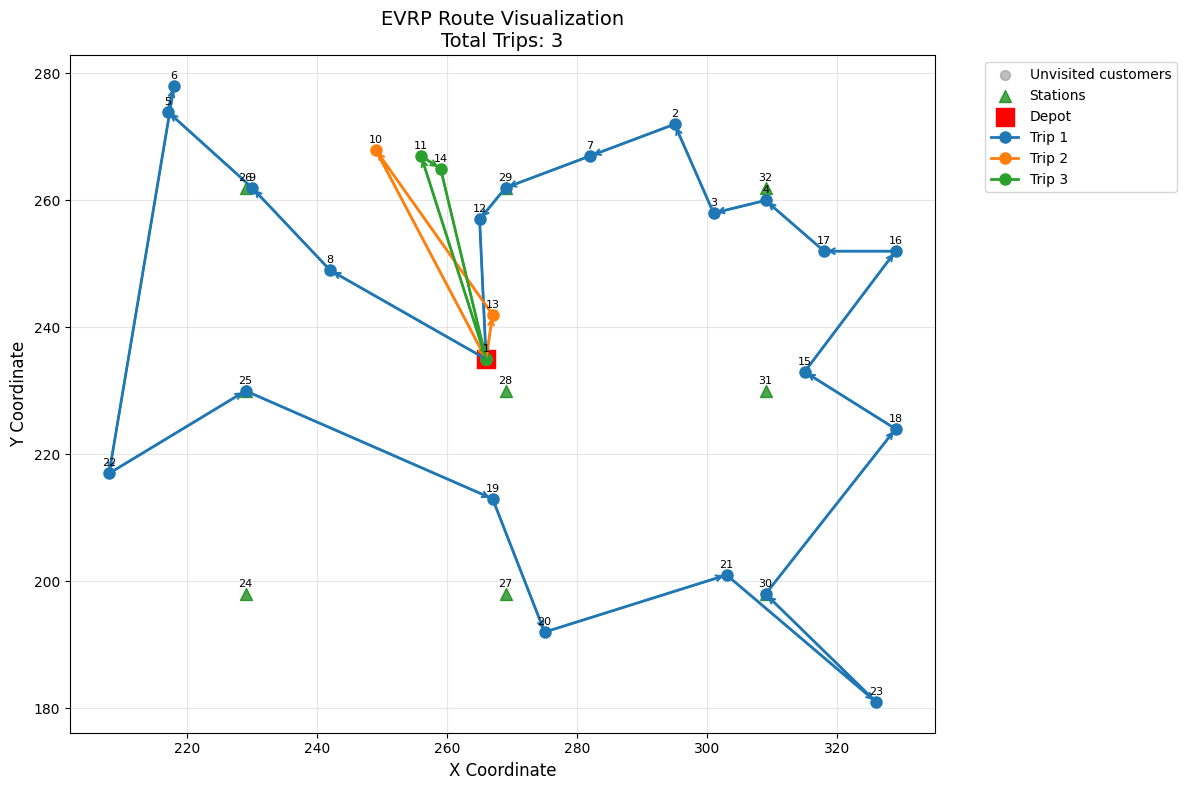

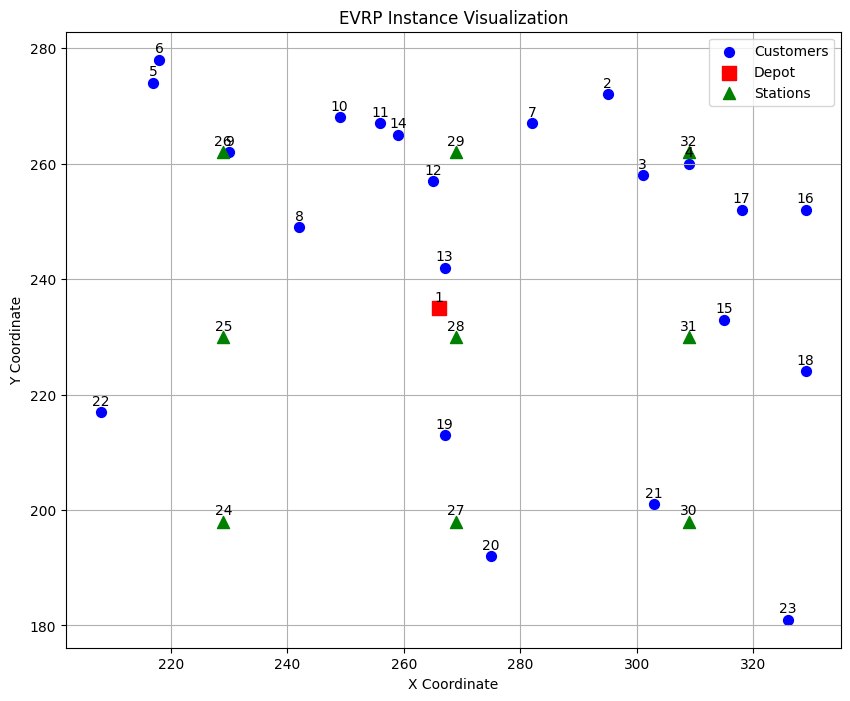

In [6]:
print(calcular_distancia_total(ga.evrp_data, rota))
plot_single_route_with_trips(ga.evrp_data, rota)
plot_evrp_instance(ga.evrp_data)

In [ ]:
print(calcular_distancia_total(ga.evrp_data, rota))
plot_single_route_with_trips(ga.evrp_data, rota)
plot_evrp_instance(ga.evrp_data)